In [1]:
# change root path one level up
import os
os.chdir("..")

In [2]:
# lightgbm and optuna
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pytz
import time
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import datetime, timedelta

CAT_FEATURES = []
NUM_FEATURES = [
    "connectionTime_hour_x",
    "connectionTime_hour_y",
    "connectionTime_month_x",
    "connectionTime_month_y",
    "connectionTime_weekday_x",
    "connectionTime_weekday_y",
]
TARGET = "kWhDelivered"


In [3]:
sessions = pd.read_csv("./data/caltech_test_data.csv", index_col=[0, 1])
# drop idle_time column
sessions = sessions.drop(
    columns=["idle_time", "Requested_parking_time", "parking_time"]
)
for cols in CAT_FEATURES:
    sessions[cols] = sessions[cols].astype("category")
sessions = sessions[NUM_FEATURES + CAT_FEATURES + [TARGET]]
sessions


connectionTime_hour_x  \
connection_time_copy _id                                               
2018-04-30           5bc915caf9af8b0dad3c0660          -5.000000e-01   
2018-05-07           5bc917d0f9af8b0dc677b8bb          -2.588190e-01   
2018-05-11           5bc9190ff9af8b0dc677b9c1          -5.000000e-01   
2018-05-14           5bc919c3f9af8b0dc677ba32           8.770390e-14   
                     5bc919c3f9af8b0dc677ba62          -2.588190e-01   
...                                                              ...   
2019-12-30           5e1fbc9ff9af8b5391bcd6fc          -7.071068e-01   
                     5e1fbc9ff9af8b5391bcd700          -1.000000e+00   
2019-12-31           5e210e1ff9af8b57bb4f54fa          -5.000000e-01   
                     5e210e1ff9af8b57bb4f54fd          -9.659258e-01   
                     5e210e1ff9af8b57bb4f5500           1.133298e-14   

                                               connectionTime_hour_y  \
connection_time_copy _id                                               
2018-04-30           5bc915caf9af8b0dad3c0660           8.660254e-01   
2018-05-07           5bc917d0f9af8b0dc677b8bb           9.659258e-01   
2018-05-11           5bc9190ff9af8b0dc677b9c1           8.660254e-01   
2018-05-14           5bc919c3f9af8b0dc677ba32           1.000000e+00   
                     5bc919c3f9af8b0dc677ba62          -9.659258e-01   
...                                                              ...   
2019-12-30           5e1fbc9ff9af8b5391bcd6fc           7.071068e-01   
                     5e1fbc9ff9af8b5391bcd700          -9.512791e-14   
2019-12-31           5e210e1ff9af8b57bb4f54fa           8.660254e-01   
                     5e210e1ff9af8b57bb4f54fd           2.588190e-01   
                     5e210e1ff9af8b57bb4f5500          -1.000000e+00   

                                               connectionTime_month_x  \
connection_time_copy _id                                                
2018-04-30           5bc915caf9af8b0dad3c0660                0.892254   
2018-05-07           5bc917d0f9af8b0dc677b8bb                0.565554   
2018-05-11           5bc9190ff9af8b0dc677b9c1               -0.232105   
2018-05-14           5bc919c3f9af8b0dc677ba32               -0.742684   
                     5bc919c3f9af8b0dc677ba62               -0.802694   
...                                                               ...   
2019-12-30           5e1fbc9ff9af8b5391bcd6fc                0.968119   
                     5e1fbc9ff9af8b5391bcd700                0.974267   
2019-12-31           5e210e1ff9af8b57bb4f54fa                0.998482   
                     5e210e1ff9af8b57bb4f54fd                0.999571   
                     5e210e1ff9af8b57bb4f5500                0.999519   

                                               connectionTime_month_y  \
connection_time_copy _id                                                
2018-04-30           5bc915caf9af8b0dad3c0660               -0.451533   
2018-05-07           5bc917d0f9af8b0dc677b8bb                0.824711   
2018-05-11           5bc9190ff9af8b0dc677b9c1                0.972691   
2018-05-14           5bc919c3f9af8b0dc677ba32                0.669642   
                     5bc919c3f9af8b0dc677ba62                0.596391   
...                                                               ...   
2019-12-30           5e1fbc9ff9af8b5391bcd6fc               -0.250491   
                     5e1fbc9ff9af8b5391bcd700               -0.225399   
2019-12-31           5e210e1ff9af8b57bb4f54fa               -0.055088   
                     5e210e1ff9af8b57bb4f54fd               -0.029276   
                     5e210e1ff9af8b57bb4f5500                0.030998   

                                               connectionTime_weekday_x  \
connection_time_copy _id                                                  
2018-04-30           5bc915caf9af8b0dad3c0660              9.555728e-01   
2018-05-07           5bc917d0f9af8b0dc677b8bb   

In [4]:
# find dates 30, 60, 120, 240, 360, 480, 600 days before 2020-12-01 and make a list of them
dates = []
for i in [30, 60, 120, 240, 360, 480]:
    dates.append((datetime(2019, 12, 1) - timedelta(days=i)).strftime("%Y-%m-%d"))
dates


['2019-11-01',
 '2019-10-02',
 '2019-08-03',
 '2019-04-05',
 '2018-12-06',
 '2018-08-08']

In [5]:
# make 6 partitions for training starting with dates[i] and ending with datetime(2020, 12, 1)
train_sessions = []
for i in range(len(dates)):
    train_sessions.append(sessions.loc[dates[i] : "2019-12-01"])
    # print number of sessions in each partition
    print(train_sessions[i].shape)


(196, 7)
(403, 7)
(910, 7)
(2127, 7)
(3627, 7)
(4779, 7)


In [6]:
# testing data is collected from Dec. 1, 2018 to Jan. 1, 2019
test = sessions.loc[(slice("2019-12-01", "2020-01-01"), slice(None)), :]
# print test size
print(test.shape)


(157, 7)


In [9]:
def train_lgb(train, params, num_rounds=200, early_stopping_rounds=10):
    # create lgb datasets
    train_data = lgb.Dataset(
        train.drop(columns=[TARGET]),
        label=train[TARGET],
        categorical_feature=CAT_FEATURES,
    )
    # train model
    model = lgb.train(params, train_data, num_rounds, verbose_eval=False)
    return model


# optimize hyperparameters of lightgbm model using optuna
def objective(trial, train_opt, val_opt):
    # define hyperparameters
    params = {
        "objective": "regression_l1",
        "metric": "mae",
        "verbose": -1,
        "seed": 42,
        "num_leaves": trial.suggest_int("num_leaves", 2, 200),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "min_data": trial.suggest_int("min_data", 1, 100),
        # regularization
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-3, 1e3),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-3, 1e3),
    }
    # train model
    model = train_lgb(
        train_opt, params, num_rounds=200, early_stopping_rounds=10
    )
    # predict on validation set
    y_pred = model.predict(val_opt.drop(columns=[TARGET]))
    # calculate mae
    mae = np.mean(np.abs(val_opt[TARGET] - y_pred))
    return mae


def run_hp(train, n_trials=100):
    train_opt = train.copy()
    # keep 20% of training data from the end for validation
    val_opt = train.iloc[-int(0.2 * len(train)) :].copy()
    # time the training
    start = time.time()
    # Wrap the objective inside a lambda and call objective inside it
    func = lambda trial: objective(trial, train_opt, val_opt)
    # optimize hyperparameters
    study = optuna.create_study(direction="minimize")
    study.optimize(func, n_trials=n_trials)
    # print best hyperparameters
    print("Best hyperparameters: ", study.best_params)
    # train model with best hyperparameters
    model = train_lgb(
        train, study.best_params, num_rounds=200, early_stopping_rounds=10
    )
    log_time = time.time() - start
    # print time taken to train
    print("Time taken to train: ", time.time() - start)
    del train_opt, val_opt
    return model, log_time


In [10]:
# train model with best hyperparameters
model_0, t_0 = run_hp(train_sessions[0], n_trials=100)
model_1, t_1 = run_hp(train_sessions[1], n_trials=100)
model_2, t_2 = run_hp(train_sessions[2], n_trials=100)
model_3, t_3 = run_hp(train_sessions[3], n_trials=100)
model_4, t_4 = run_hp(train_sessions[4], n_trials=100)
model_5, t_5 = run_hp(train_sessions[5], n_trials=100)

[I 2023-05-16 10:53:39,918] A new study created in memory with name: no-name-2c5fa7ab-3dbf-4da7-9b03-6c5e6a851c33
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-16 10:53:40,037] Trial 0 finished with value: 5.273680177002935 and parameters: {'num_leaves': 176, 'max_depth': 3, 'learning_rate': 0.08771296541746323, 'min_data': 83, 'lambda_l1': 0.0021965631192101516, 'lambda_l2': 0.03968768757017783}. Best is trial 0 with value: 5.273680177002935.
/Users/evg

Best hyperparameters:  {'num_leaves': 154, 'max_depth': 5, 'learning_rate': 0.09105063087208062, 'min_data': 3, 'lambda_l1': 0.0014737445900393326, 'lambda_l2': 0.17871793898780924}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 196, number of used features: 6
[LightGBM] [Info] Start training from score 7.685681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[I 2023-05-16 10:54:01,825] A new study created in memory with name: no-name-ed89fd61-ea32-4793-9d48-a4f3f10a804d
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-16 10:54:01,884] Trial 0 finished with value: 4.2310199593002125 and parameters: {'num_leaves': 14, 'max_depth': 2, 'learning_rate': 0.010927831853872836, 'min_data': 31, 'lambda_l1': 0.12619702550731884, 'lambda_l2': 29.32995659968387}. Best is trial 0 with value: 4.2310199593002125.
/Users/evgen

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-16 10:54:01,999] Trial 2 finished with value: 4.7216562666329285 and parameters: {'num_leaves': 154, 'max_depth': 5, 'learning_rate': 0.0268600845407076, 'min_data': 49, 'lambda_l1': 113.91382239071865, 'lambda_l2': 404.71540259509476}. Best is trial 1 with value: 4.130752073827372.
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_fe

Best hyperparameters:  {'num_leaves': 154, 'max_depth': 5, 'learning_rate': 0.0893183285451185, 'min_data': 1, 'lambda_l1': 0.011912534600160925, 'lambda_l2': 2.611555531720695}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 403, number of used features: 6
[LightGBM] [Info] Start training from score 8.195498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2023-05-16 10:54:22,726] A new study created in memory with name: no-name-983b5fcf-0fda-4b0b-bbcb-49994b157669
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-16 10:54:22,832] Trial 0 finished with value: 4.175779256454627 and parameters: {'num_leaves': 46, 'max_depth': 3, 'learning_rate': 0.019408189427702078, 'min_data': 91, 'lambda_l1': 0.03682263142042825, 'lambda_l2': 191.49114953913488}. Best is trial 0 with value: 4.175779256454627.
/Users/evgeny

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Time taken to train:  20.89891505241394


/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-16 10:54:22,940] Trial 2 finished with value: 4.2383493251794135 and parameters: {'num_leaves': 70, 'max_depth': 5, 'learning_rate': 0.06266680212401972, 'min_data': 58, 'lambda_l1': 19.494756875792365, 'lambda_l2': 225.91443074219123}. Best is trial 0 with value: 4.175779256454627.
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_fe

Best hyperparameters:  {'num_leaves': 99, 'max_depth': 5, 'learning_rate': 0.05868283897184959, 'min_data': 2, 'lambda_l1': 2.1103181569554104, 'lambda_l2': 0.8568505548297471}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 910, number of used features: 6
[LightGBM] [Info] Start training from score 7.874496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2023-05-16 10:54:48,214] A new study created in memory with name: no-name-2b4f6dd6-4137-4af3-86a2-ab1a77ad0679


Time taken to train:  25.48406195640564


/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-16 10:54:48,637] Trial 0 finished with value: 4.826877344061616 and parameters: {'num_leaves': 157, 'max_depth': 5, 'learning_rate': 0.003510201684536058, 'min_data': 77, 'lambda_l1': 2.7099548565390466, 'lambda_l2': 0.001648217958830583}. Best is trial 0 with value: 4.826877344061616.
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical

Best hyperparameters:  {'num_leaves': 79, 'max_depth': 5, 'learning_rate': 0.08952351115037217, 'min_data': 1, 'lambda_l1': 0.01845281175973531, 'lambda_l2': 187.7345879127403}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 2127, number of used features: 6
[LightGBM] [Info] Start training from score 7.641428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-05-16 10:55:28,857] A new study created in memory with name: no-name-83489600-59c3-47b6-bc1f-276095f3e630


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Time taken to train:  40.64057898521423


/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-16 10:55:29,094] Trial 0 finished with value: 4.5838593087546045 and parameters: {'num_leaves': 71, 'max_depth': 4, 'learning_rate': 0.011521878994754525, 'min_data': 69, 'lambda_l1': 0.12652793356559172, 'lambda_l2': 633.1689828379351}. Best is trial 0 with value: 4.5838593087546045.
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_

Best hyperparameters:  {'num_leaves': 54, 'max_depth': 5, 'learning_rate': 0.08978682963795366, 'min_data': 5, 'lambda_l1': 1.741691550009205, 'lambda_l2': 15.005728386681094}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 3627, number of used features: 6
[LightGBM] [Info] Start training from score 8.204823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2023-05-16 10:56:11,140] A new study created in memory with name: no-name-d6b6a400-3ea8-4246-a621-8e62b8f75606


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-16 10:56:11,358] Trial 0 finished with value: 4.7120554774470085 and parameters: {'num_leaves': 75, 'max_depth': 2, 'learning_rate': 0.004318888215816079, 'min_data': 9, 'lambda_l1': 0.446913517704848, 'lambda_l2': 0.5836754524802897}. Best is trial 0 with value: 4.7120554774470085.
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_fe

Best hyperparameters:  {'num_leaves': 43, 'max_depth': 5, 'learning_rate': 0.0880449404359511, 'min_data': 8, 'lambda_l1': 0.007716174001897934, 'lambda_l2': 20.413125107532668}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 4779, number of used features: 6
[LightGBM] [Info] Start training from score 9.001270
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

In [11]:
# print times
print("Time taken to train model 0: ", t_0)
print("Time taken to train model 1: ", t_1)
print("Time taken to train model 2: ", t_2)
print("Time taken to train model 3: ", t_3)
print("Time taken to train model 4: ", t_4)
print("Time taken to train model 5: ", t_5)

Time taken to train model 0:  21.905951023101807
Time taken to train model 1:  20.89891505241394
Time taken to train model 2:  25.484061002731323
Time taken to train model 3:  40.64056396484375
Time taken to train model 4:  42.28081679344177
Time taken to train model 5:  38.49706292152405


In [12]:
# test model on test data
def test_lgb(model, test):
    # time the testing
    start = time.time()
    # test model
    y_pred = model.predict(test.drop(columns=[TARGET]))
    y_true = test[TARGET]
    # print time taken to test
    print("Time taken to test: ", time.time() - start)
    return y_pred, y_true


def test_lgb_timed(model, test, n_iters=20):
    runtime_list = []
    for i in range(n_iters):
        # time the testing
        start = time.time()
        # test model
        y_pred = model.predict(test.drop(columns=[TARGET]))
        y_true = test[TARGET]
        # print time taken to test
        runtime_list.append(time.time() - start)
    print(np.mean(runtime_list))
    return y_pred, y_true


In [13]:
y_pred_0, y_true_0 = test_lgb_timed(model_0, test)
y_pred_1, y_true_1 = test_lgb_timed(model_1, test)
y_pred_2, y_true_2 = test_lgb_timed(model_2, test)
y_pred_3, y_true_3 = test_lgb_timed(model_3, test)
y_pred_4, y_true_4 = test_lgb_timed(model_4, test)
y_pred_5, y_true_5 = test_lgb_timed(model_5, test)


0.0012154340744018554
0.0013555049896240234
0.001025986671447754
0.000888204574584961
0.0009297251701354981
0.0009830713272094727


In [14]:
# evaluate smape of lightgbm model
def smape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + y_pred))) * 100


def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


# evaluate smape for each time interval

print("smape for time interval 0: ", smape(y_true_0.values, y_pred_0))
print("smape for time interval 1: ", smape(y_true_1.values, y_pred_1))
print("smape for time interval 2: ", smape(y_true_2.values, y_pred_2))
print("smape for time interval 3: ", smape(y_true_3.values, y_pred_3))
print("smape for time interval 4: ", smape(y_true_4.values, y_pred_4))
print("smape for time interval 5: ", smape(y_true_5.values, y_pred_5))


smape for time interval 0:  33.047663599815195
smape for time interval 1:  33.40282261690808
smape for time interval 2:  33.75526220456203
smape for time interval 3:  30.91041735426282
smape for time interval 4:  31.39660790164273
smape for time interval 5:  30.907287446955618


In [15]:
# make a table with the results
results = pd.DataFrame(
    {
        "time_interval": [30, 60, 120, 240, 360, 480],
        "smape": [
            smape(y_true_0.values, y_pred_0),
            smape(y_true_1.values, y_pred_1),
            smape(y_true_2.values, y_pred_2),
            smape(y_true_3.values, y_pred_3),
            smape(y_true_4.values, y_pred_4),
            smape(y_true_5.values, y_pred_5),
        ],
    }
)
# add a column for mae
results["mae"] = [
    mae(y_true_0.values, y_pred_0),
    mae(y_true_1.values, y_pred_1),
    mae(y_true_2.values, y_pred_2),
    mae(y_true_3.values, y_pred_3),
    mae(y_true_4.values, y_pred_4),
    mae(y_true_5.values, y_pred_5),
]
results


,time_interval,smape,mae
0,30,33.047664,5.177373
1,60,33.402823,5.729720
2,120,33.755262,5.494731
3,240,30.910417,4.346333
4,360,31.396608,4.478784
5,480,30.907287,4.374860


In [16]:
results.to_csv("results/lightgbm_energy_nologs.csv", index=False)

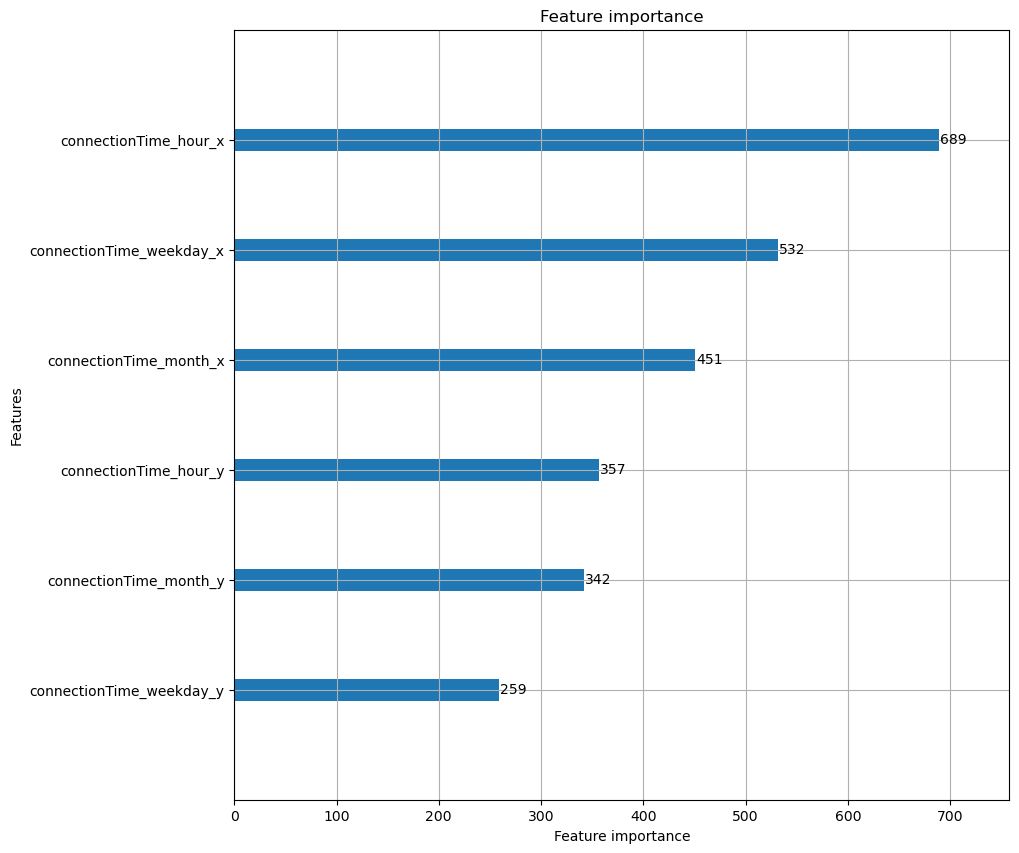

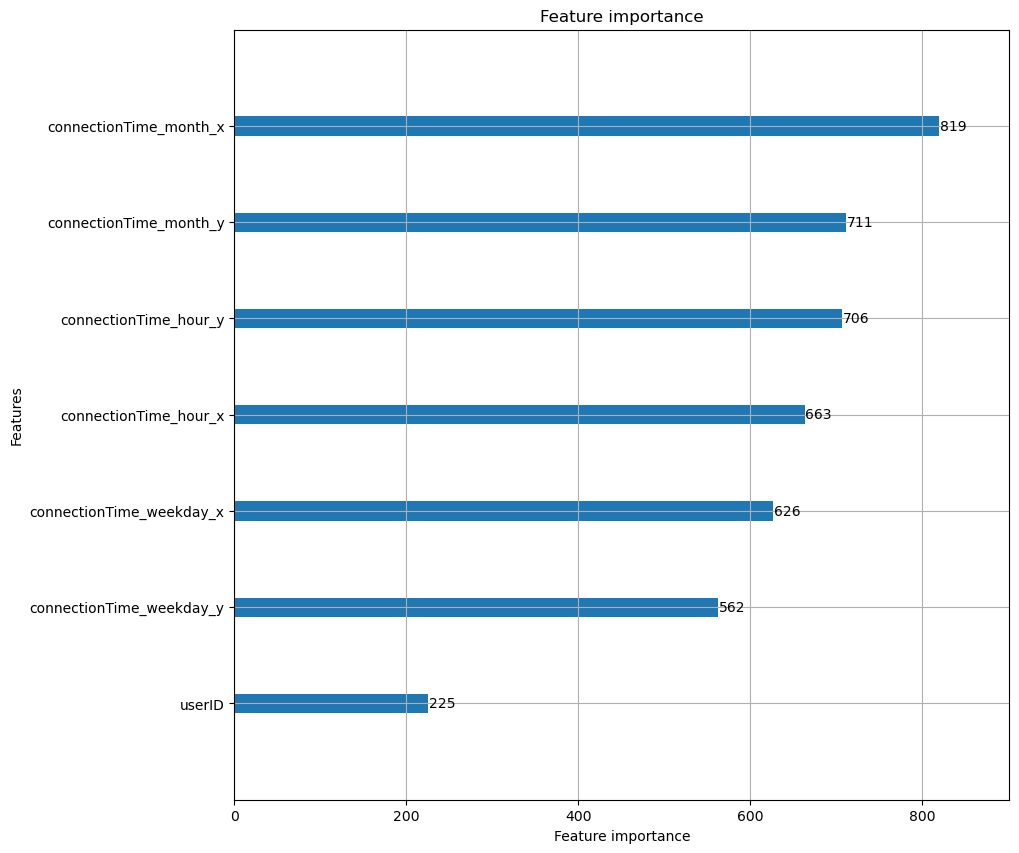

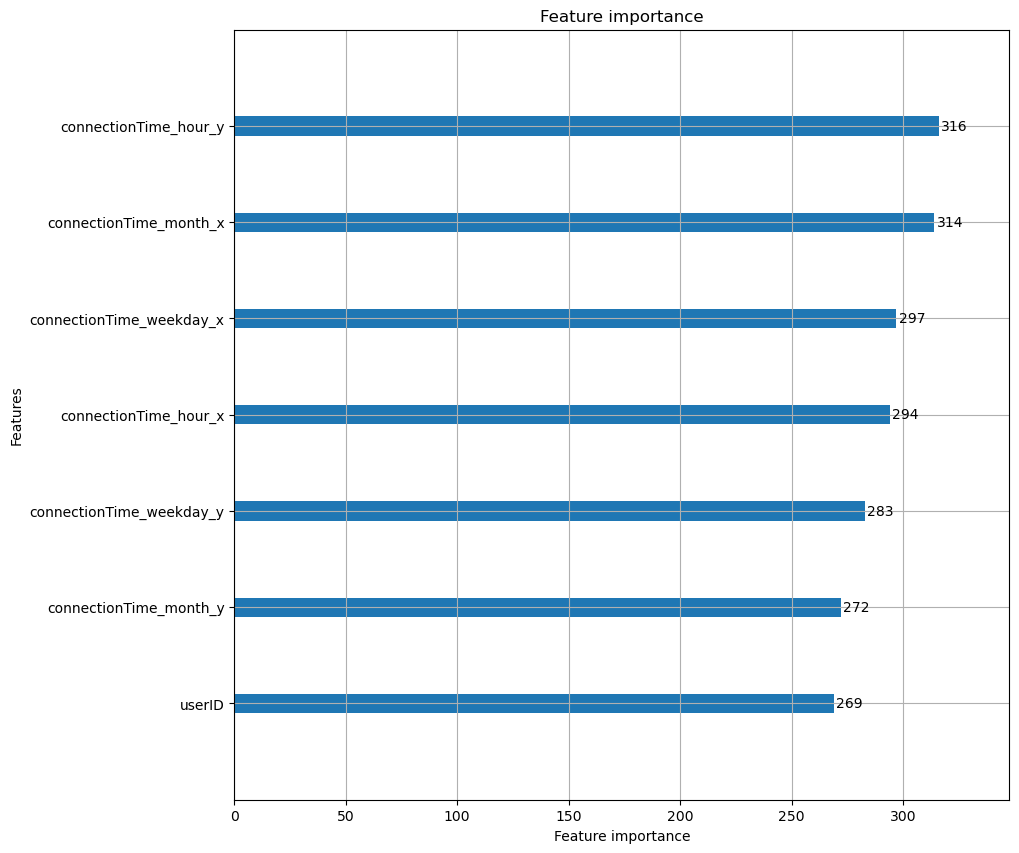

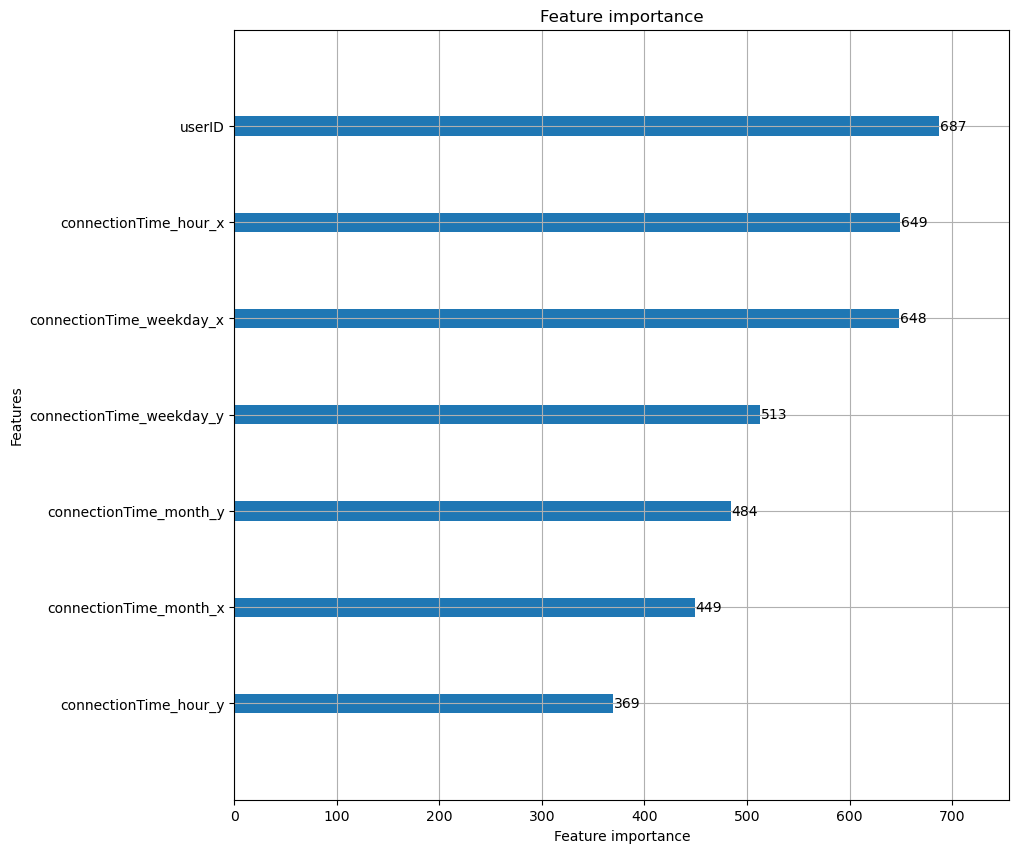

In [51]:
# feature importance of lightgbm model
def plot_feature_importance(model, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    lgb.plot_importance(model, ax=ax)
    plt.show()


# plot feature importance for each time interval
plot_feature_importance(model_0)
plot_feature_importance(model_1)
plot_feature_importance(model_2)
plot_feature_importance(model_3)
